In [25]:
import sys
sys.path.append("../src")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from exact_solution import solve_master_equation, one_excited_emitter_state

In [26]:
# hand-compiled
def load_data(file_path):
    data = {f"{i:04b}": [] for i in range(16)}
    with open(file_path, 'r') as fp:
        lines = fp.readlines()

    for line in lines:
        if not line:
            continue
        l = line.strip().lstrip('[').rstrip(']')
        for l, v in zip(data.values(), l.split(',')):
            l.append(float(v.strip(' ')))

    return data

jaqal_results = load_data('../data/QSCOUT/exp_data.txt')
jaqal_results = pd.DataFrame(jaqal_results)

jaqal_results[['1000', '0100', '0010', '0001']] = jaqal_results[['1000', '0100', '0010', '0001']].divide(jaqal_results[['1000', '0100', '0010', '0001']].sum(axis=1), axis=0)
jaqal_results['avg_1000_0100'] = jaqal_results[['1000', '0100']].mean(axis=1)

In [27]:
run1 = np.load('../data/QSCOUT/superstaq 2000 shots/Experiment Probabilities_1.npy', allow_pickle=True) 
run2 = np.load('../data/QSCOUT/superstaq 2000 shots/Experiment Probabilities_2.npy', allow_pickle=True)
run3 = np.load('../data/QSCOUT/superstaq 2000 shots/Experiment Probabilities_3.npy', allow_pickle=True)

lines = []
for timestep in zip(run1, run2, run3):
    timestep_data = {key: _ for key in timestep[0].keys()}
    for key, _ in timestep_data.items():
        timestep_data[key] = (np.mean([timestep[0][key], timestep[1][key], timestep[2][key]]))
    lines.append(timestep_data)
    
superstaq_results = pd.DataFrame(lines)

superstaq_results_norm = superstaq_results.copy()
superstaq_results_norm[['1000', '0100', '0010', '0001']] = superstaq_results_norm[['1000', '0100', '0010', '0001']].divide(superstaq_results_norm[['1000', '0100', '0010', '0001']].sum(axis=1), axis=0)
superstaq_results_norm['avg_0100_0010'] = superstaq_results_norm[['0100', '0010']].mean(axis=1)

In [28]:
# mirror swaps, 3 runs of 2000 shots
run1 = np.load('../data/QSCOUT/mirror_swaps/Experiment Probabilities.npy', allow_pickle=True) 
run2 = np.load('../data/QSCOUT/mirror_swaps/Experiment Probabilities (1).npy', allow_pickle=True)
run3 = np.load('../data/QSCOUT/mirror_swaps/Experiment Probabilities (2).npy', allow_pickle=True)

lines = []
for timestep in zip(run1, run2, run3):
    timestep_data = {key: _ for key in timestep[0].keys()}
    for key, _ in timestep_data.items():
        timestep_data[key] = (np.mean([timestep[0][key], timestep[1][key], timestep[2][key]]))
    lines.append(timestep_data)
    
mirror_results = pd.DataFrame(lines)

mirror_results.loc[10:, ['1000', '0001']] = mirror_results.loc[10:, ['0001', '1000']].values

mirror_results[['1000', '0100', '0010', '0001']] = mirror_results[['1000', '0100', '0010', '0001']].divide(mirror_results[['1000', '0100', '0010', '0001']].sum(axis=1), axis=0)
mirror_results['avg_0100_0010'] = mirror_results[['0100', '0010']].mean(axis=1)

In [29]:
N = 3
g = 2
kappa = 5
times = np.linspace(0, 3, 51)

In [30]:
initial_state = one_excited_emitter_state(N, 1)
qutip_results = solve_master_equation(N, g, kappa, initial_state, times)

/var/folders/ds/t6zgkw3n75d3gzz89xmkcncm0000gn/T/ipykernel_16949/269954388.py:76: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


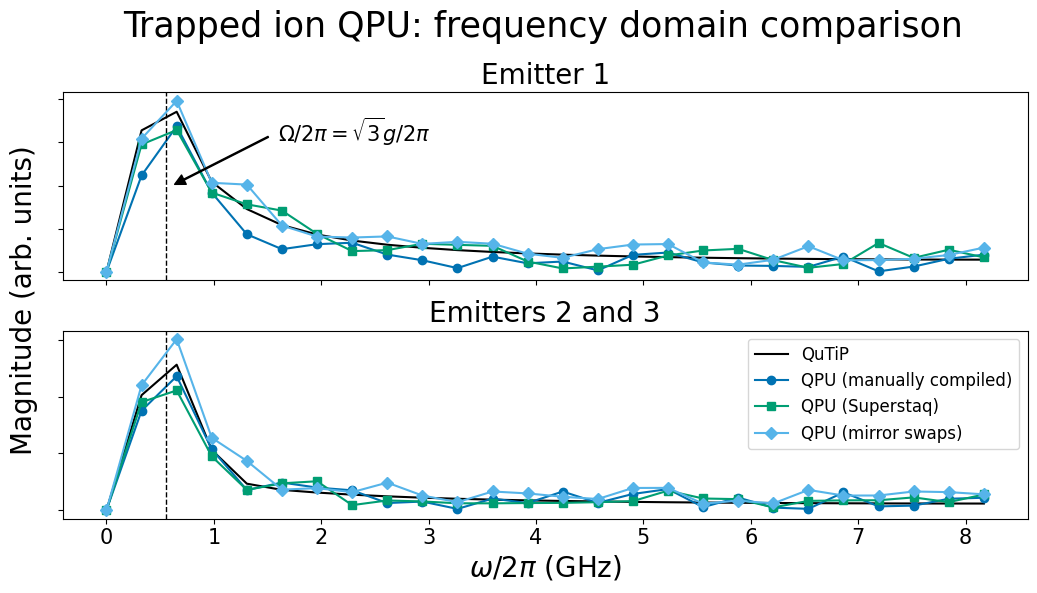

In [31]:
# Paper fourier for AQT
rabi_freq = np.sqrt(3) * g / (2*np.pi)

n = len(jaqal_results)

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

freqs = np.fft.rfftfreq(n, times[1] - times[0])

##
em1_fft_qt = np.abs(np.fft.rfft(qutip_results["Emitter 1"] - qutip_results["Emitter 1"].mean(), n))
axes[0].plot(freqs, em1_fft_qt, label="QuTiP", color='black')

em1_fft = np.abs(np.fft.rfft(jaqal_results["0010"] - jaqal_results["0010"].mean(), n))
axes[0].plot(freqs, em1_fft, label="QPU (manually compiled)", marker='o', color='#0072b2')

axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[0].set_title("Emitter 1", fontsize=20)
axes[0].axvline(rabi_freq, lw=1, color='black', linestyle='--')

##

em23_fft = np.abs(np.fft.rfft(qutip_results["Emitter 2"] - qutip_results["Emitter 2"].mean(), n))
axes[1].plot(freqs, em23_fft, label="QuTiP", color='black')

em23_fft = np.abs(np.fft.rfft(jaqal_results["avg_1000_0100"] - jaqal_results["avg_1000_0100"].mean(), n))
axes[1].plot(freqs, em23_fft, label="QPU (manually compiled)", marker='o', color='#0072b2')

axes[1].tick_params(axis='x', labelsize=15)
axes[1].set_yticklabels([])
axes[1].set_title("Emitters 2 and 3", fontsize=20)
axes[1].axvline(rabi_freq, lw=1, color='black', linestyle='--')


### superstaq compiled
em1_fft_superstaq = np.abs(np.fft.rfft(superstaq_results_norm["1000"] - superstaq_results_norm["1000"].mean(), n))
axes[0].plot(freqs, em1_fft_superstaq, label="QPU (Superstaq)", marker='s', color='#009e73')

em23_fft_superstaq = np.abs(np.fft.rfft(superstaq_results_norm["avg_0100_0010"] - superstaq_results_norm["avg_0100_0010"].mean(), n))
axes[1].plot(freqs, em23_fft_superstaq, label="QPU (Superstaq)", marker='s', color='#009e73')


### mirror swaps
em1_fft_nox = np.abs(np.fft.rfft(mirror_results["1000"] - mirror_results["1000"].mean(), n))
axes[0].plot(freqs, em1_fft_nox, label="QPU (mirror swaps)", marker='D', color='#56b4e9')

em23_fft_nox = np.abs(np.fft.rfft(mirror_results["avg_0100_0010"] - mirror_results["avg_0100_0010"].mean(), n))
axes[1].plot(freqs, em23_fft_nox, label="QPU (mirror swaps)", marker='D', color='#56b4e9')


axes[1].set_xlabel(r"$\omega / 2\pi$ (GHz)", fontsize=20)


##
fig.text(-0.04, 0.72, "Magnitude (arb. units)", transform=axes[0].transAxes,
        ha='center', va='top', fontsize=20, rotation=90)
##
axes[0].annotate(
    r'$\Omega/2\pi = \sqrt{3}g/2\pi$', # the text of the annotation
    fontsize=15,
    xy=(rabi_freq + 0.06, 2),       # the point (x,y) to annotate
    xytext=(1.6, 3),   # the position of the text (x,y)
    arrowprops=dict(
        arrowstyle="simple, tail_width=0.05, head_width=.5, head_length=.5",
        connectionstyle="arc3",  # connection style
        facecolor='black',
        relpos=(-0.05, 0.4),
    )
)
##

fig.suptitle("Trapped ion QPU: frequency domain comparison", fontsize=25)
plt.legend(fontsize=12)
plt.tight_layout()
fig.show()

In [32]:
fig.savefig("../figures/QSCOUT_fourier.eps")